In [1]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
anchor_scales = [128, 256, 512]
aspect_ratio = [0.5, 1, 2.0]
strides = 16

In [4]:
image = cv2.imread("sample.jpg")
img_height, img_width = image.shape[:2]
print(img_width, img_height)

bboxes = [[36,205,180,289], [51,160,150,292], [295, 138, 450, 290]]

500 375


1.6 2.1333333333333333
[[ 57 437 288 616]
 [ 81 341 240 622]
 [472 294 720 618]]


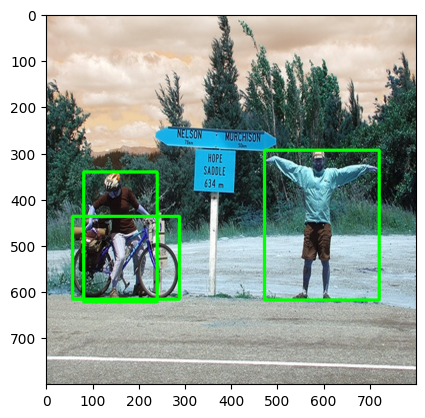

In [5]:
## 이미지를 800, 800 크기로 resize하고 bounding box도 rescale한다.
img = cv2.resize(image, dsize=(800, 800), interpolation=cv2.INTER_CUBIC)

## original image size : (1333, 2000)
Wratio = 800/img_width
Hratio = 800/img_height
print(Wratio, Hratio)

ratioList = [Wratio, Hratio, Wratio, Hratio]
bbox = []

for box in bboxes:
    box = [int(a*b) for a, b in zip(box, ratioList)]
    """
    bbox : [ 223  782  623 1074]
    223 * 0.4
    782 * 0.6001500375093773
    623 * 0.4
    1074 * 0.6001500375093773
    """
    bbox.append(box)
    
bbox = np.array(bbox)
print(bbox)

img_clone = np.copy(img)
for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox[i][0], bbox[i][1]), (bbox[i][2], bbox[i][3]), color=(0, 255, 0), thickness=5)
plt.imshow(img_clone)
plt.show()

In [6]:
def generate_anchors(anchor_scales, aspect_ratios, dtype=torch.float32, device="cpu"):
    ## 중심점이 (0, 0)인 len(anchor_scales) * len(aspect_ratios)개의 anchor를 생성.
    anchor_scales = torch.as_tensor(anchor_scales, dtype=dtype, device=device)
    aspect_ratios = torch.as_tensor(aspect_ratios, dtype=dtype, device=device)

    h_ratios = torch.sqrt(aspect_ratios)
    w_ratios = 1.0 / h_ratios

    ## len(ratios) * len(scales)
    ws = (w_ratios[:, None] * anchor_scales[None, :]).view(-1)
    hs = (h_ratios[:, None] * anchor_scales[None, :]).view(-1)
    base_anchors = torch.stack([-ws, -hs, ws, hs], dim=1) / 2

    return base_anchors.round()

In [7]:
feature_map_size = 800 // strides
anchors = generate_anchors(anchor_scales, aspect_ratio)
print(len(anchors))
print(anchors)

9
tensor([[ -91.,  -45.,   91.,   45.],
        [-181.,  -91.,  181.,   91.],
        [-362., -181.,  362.,  181.],
        [ -64.,  -64.,   64.,   64.],
        [-128., -128.,  128.,  128.],
        [-256., -256.,  256.,  256.],
        [ -45.,  -91.,   45.,   91.],
        [ -91., -181.,   91.,  181.],
        [-181., -362.,  181.,  362.]])


In [8]:
feature_map_height, feature_map_width = 800//strides, 800//strides
shifts_x = torch.arange(0, feature_map_width, dtype=torch.float32) * strides
shifts_y = torch.arange(0, feature_map_height, dtype=torch.float32) * strides

print(shifts_x, shifts_y)

tensor([  0.,  16.,  32.,  48.,  64.,  80.,  96., 112., 128., 144., 160., 176.,
        192., 208., 224., 240., 256., 272., 288., 304., 320., 336., 352., 368.,
        384., 400., 416., 432., 448., 464., 480., 496., 512., 528., 544., 560.,
        576., 592., 608., 624., 640., 656., 672., 688., 704., 720., 736., 752.,
        768., 784.]) tensor([  0.,  16.,  32.,  48.,  64.,  80.,  96., 112., 128., 144., 160., 176.,
        192., 208., 224., 240., 256., 272., 288., 304., 320., 336., 352., 368.,
        384., 400., 416., 432., 448., 464., 480., 496., 512., 528., 544., 560.,
        576., 592., 608., 624., 640., 656., 672., 688., 704., 720., 736., 752.,
        768., 784.])


In [9]:
shift_y, shift_x = torch.meshgrid(shifts_y, shifts_x)
shift_x = shift_x.reshape(-1)
shift_y = shift_y.reshape(-1)

print(shifts_x, shifts_y)

tensor([  0.,  16.,  32.,  48.,  64.,  80.,  96., 112., 128., 144., 160., 176.,
        192., 208., 224., 240., 256., 272., 288., 304., 320., 336., 352., 368.,
        384., 400., 416., 432., 448., 464., 480., 496., 512., 528., 544., 560.,
        576., 592., 608., 624., 640., 656., 672., 688., 704., 720., 736., 752.,
        768., 784.]) tensor([  0.,  16.,  32.,  48.,  64.,  80.,  96., 112., 128., 144., 160., 176.,
        192., 208., 224., 240., 256., 272., 288., 304., 320., 336., 352., 368.,
        384., 400., 416., 432., 448., 464., 480., 496., 512., 528., 544., 560.,
        576., 592., 608., 624., 640., 656., 672., 688., 704., 720., 736., 752.,
        768., 784.])


In [16]:
shifts = torch.stack([shift_x, shift_y, shift_x, shift_y], dim=1)
shifts_anchor = shifts.view(-1, 1, 4) + anchors.view(1, -1, 4)
print(shifts_anchor.shape)
print(shifts_anchor)

torch.Size([2500, 9, 4])
tensor([[[ -91.,  -45.,   91.,   45.],
         [-181.,  -91.,  181.,   91.],
         [-362., -181.,  362.,  181.],
         ...,
         [ -45.,  -91.,   45.,   91.],
         [ -91., -181.,   91.,  181.],
         [-181., -362.,  181.,  362.]],

        [[ -75.,  -45.,  107.,   45.],
         [-165.,  -91.,  197.,   91.],
         [-346., -181.,  378.,  181.],
         ...,
         [ -29.,  -91.,   61.,   91.],
         [ -75., -181.,  107.,  181.],
         [-165., -362.,  197.,  362.]],

        [[ -59.,  -45.,  123.,   45.],
         [-149.,  -91.,  213.,   91.],
         [-330., -181.,  394.,  181.],
         ...,
         [ -13.,  -91.,   77.,   91.],
         [ -59., -181.,  123.,  181.],
         [-149., -362.,  213.,  362.]],

        ...,

        [[ 661.,  739.,  843.,  829.],
         [ 571.,  693.,  933.,  875.],
         [ 390.,  603., 1114.,  965.],
         ...,
         [ 707.,  693.,  797.,  875.],
         [ 661.,  603.,  843.,  965.],
  

In [14]:
img_clone3 = np.copy(img)
img_clone4 = cv2.copyMakeBorder(img_clone3,400,400,400,400,cv2.BORDER_CONSTANT, value=(255, 255, 255))
img_clone5 = np.copy(img_clone4)

for i in range(len(shifts_anchor[0])):
    x1 = int(shifts_anchor.numpy()[i][0])
    y1 = int(shifts_anchor.numpy()[i][1])
    x2 = int(shifts_anchor.numpy()[i][2])
    y2 = int(shifts_anchor.numpy()[i][3])
    
    cv2.rectangle(img_clone5, (x1+400, y1+400), (x2+400, y2+400), color=(255, 0, 0), thickness=3)

plt.figure(figsize=(10, 10))
plt.subplot(121), plt.imshow(img_clone4)
plt.subplot(122), plt.imshow(img_clone5)
plt.show()

TypeError: only size-1 arrays can be converted to Python scalars